# <font color=darkcyan> Bayesian learning </font>
#### <font color=darkorange>Metropolis-Hastings, MALA,  Hamiltonian Monte Carlo, Approximate Bayesian Computation... </font>

In [3]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [4]:
"""""""""""""""""
Required packages
"""""""""""""""""
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In a Bayesian setting, a parameter $x$ is embedded with a prior distribution $\pi$ and the observations are given by a probabilistic model:

$$
Y\sim \ell(\cdot|x)\,.
$$


The inference is then based on the posterior distribution:
$$
\pi(x|Y) = \frac{\pi(x)\ell(Y|x)}{\int\pi(u)\ell(Y|u)\mathrm{d} u}\,.
$$


In most cases the normalizing constant is not tractable:
$$
\pi(x|Y) \propto \pi(x)\ell(Y|x)\,.
$$

``Markov chain Monte Carlo (MCMC) algorithms`` provide solutions to sample from posterior distributions. ``Hamiltonian Monte Carlo (HMC)`` is a MCMC algorithm that uses gradient information to scale better to higher dimensions. It is used by software like [PyMC3](https://pymc.io/) and [Stan](https://mc-stan.org/). 

Some references on MCMC...
- **Douc R., Moulines E. and Stoffer D.**, Nonlinear time series: theory, methods and applications with R example, 2014, Chapman \& Hall.
- **Michael Betancourt, [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)** A thorough, readable reference that is the main source here

### <font color=darkorange> A few simple models </font>

<font color=darkred> Write a function returning the opposite of the log pdf of </font>
    
<font color=darkred>    i) a Gaussian random variable with mean mu and covariance matrix sigma; </font>
    
<font color=darkred>    ii) a mixture of pdf. </font>

In [3]:
def multi_gauss(mu, sigma):
    """
    Inputs
    ----------
    mu: mean of the Gaussian distribution
    sigma: covariance matrix of the Gaussian distribution
    
    Outputs
    -------
    logp: opposite of the loglikelihood
    """

    def logp(x):
        k   = mu.shape[0]
        cst       = k * np.log(2 * np.pi)
        det       = np.log(np.linalg.det(sigma))
        quad_term = np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        return (cst +  det + quad_term) * 0.5
    
    return logp

def mixture(log_prob, weights):
    """
    Inputs
    ----------
    log_prob: opposite of the likelihood of each term
    weights: weights of the components of the mixture
    
    Outputs
    -------
    logp: opposite of the loglikelihood of the mixture
    """
    
    def logp(x):
        likelihood = 0
        for j in range(np.size(weights)):
            log_marginal = -log_prob[j](x)
            likelihood   = likelihood + weights[j]*np.exp(log_marginal)
        
        return -np.log(likelihood)

    return logp

In [4]:
grid_lim = 6
# grid on which the target pdf is displayed
grid_plot = (-grid_lim, grid_lim, -grid_lim, grid_lim)
# coordinates chosen on this grid
nb_points = 100

xplot = np.linspace(-grid_lim, grid_lim, nb_points)
yplot = np.linspace(-grid_lim, grid_lim, nb_points)
Xplot, Yplot = np.meshgrid(xplot, yplot)

## <font color=darkcyan> Metropolis-Hastings algorithm </font>

``Objective target density:`` $\pi(\cdot|Y)$.

``Instrumental transition density:`` $q(x,y)$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim q(\cdot,X_k)$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y|Y)}{\pi(x|Y)}\frac{q(y,x)}{q(x,y)}\,.
$$

<font color=darkred> Write a function which returns samples from Metropolis-Hastings algorithm with Gaussian proposal density.</font>

In [5]:
def HM_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)
    
    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = st.norm(0, 1).rvs(size)
    
    for noise in tqdm(epsilon):
        
        q_new = samples[-1] + step_size*noise
       
        # acceptance rate
        old_log_p = log_prob(samples[-1]) 
        new_log_p = log_prob(q_new) 
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

## <font color=darkcyan> Metropolis Adjusted Langevin algorithm (MALA) </font>

``Objective target density:`` $\pi(\cdot|Y)$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim X_k + \frac{\sigma}{2}\nabla\log\pi(X_k|Y) + \sigma \varepsilon_{k+1}$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y|Y)}{\pi(x|Y)}\frac{q(y,x)}{q(x,y)}\,,
$$

where $q(x,y)$ is the Gaussian pdf with mean $x + \frac{\sigma}{2}\nabla\log\pi(x|Y)$ and variance $\sigma^2 I_d$.

<font color=darkred> Write a function which returns samples from MALA algorithm.</font>

In [6]:
def MALA_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)

    gradV = grad(log_prob)

    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = st.norm(0, 1).rvs(size)
    step    = 0.5/(step_size**2)
    for noise in tqdm(epsilon):
        
        grad_new = gradV(samples[-1])
        mean_new = samples[-1] - step*grad_new
        q_new    = mean_new + step_size*noise
       
        grad_y   = gradV(q_new)
        mean_y   = q_new - step*grad_y
        
        # acceptance rate
        old_log_p = log_prob(samples[-1]) + step*np.dot(q_new-mean_new,q_new-mean_new)
        new_log_p = log_prob(q_new) + step*np.dot(samples[-1]-mean_y,samples[-1]-mean_y)
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

## <font color=darkcyan> Hamiltonian Monte Carlo </font>

### <font color=darkorange> Framework </font>

The unknown  parameters are gathered into a _position_ variable, usually written $\mathbf{q}$. 
An auxiliary variable, called ``momentum`` and written $\mathbf{p}$, is introduced to define the extended joint probability distribution 

$$
\pi(\mathbf{q}, \mathbf{p}|Y) =  \pi(\mathbf{q}|Y) \pi(\mathbf{p} | \mathbf{q},Y)\,,
$$

In most cases $\pi(\mathbf{p} | \mathbf{q},Y)$ is the probability density of a Gaussian random variable with mean $0$ and variance $M$.

The ``Hamiltonian`` associated with this model is  $H(\mathbf{q}, \mathbf{p}|Y) = -\log \pi(\mathbf{q}, \mathbf{p}|Y)$ so that

$$
H(\mathbf{q}, \mathbf{p}|Y) = -\log \pi(\mathbf{p} | \mathbf{q},Y) - \log \pi(\mathbf{q}|Y) = K(\mathbf{p}, \mathbf{q}|Y) + V(\mathbf{q}|Y)\,,
$$

where $K(\mathbf{p}, \mathbf{q}|Y)$ is called the _kinetic energy_, and $V(\mathbf{q}|Y)$ is called the _potential energy_.

The dynamics of the system $(\mathbf{q}, \mathbf{p})$ is assumed to follow _Hamilton's equations_:

$$
\frac{\mathrm{d} \mathbf{q}}{\mathrm{d}t} = \frac{\partial H}{\partial \mathbf{p}} = \frac{\partial K}{\partial \mathbf{p}} + \frac{\partial V}{\partial \mathbf{p}}\\
\frac{\mathrm{d} \mathbf{p}}{\mathrm{d}t} = -\frac{\partial H}{\partial \mathbf{q}}= -\frac{\partial K}{\partial \mathbf{q}} + \frac{\partial V}{\partial \mathbf{q}}
$$


When $\pi(\mathbf{p} | \mathbf{q},Y)$ is the probability density of a Gaussian random variable with mean $0$ and variance $M$, this yields

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T M^{-1}\mathbf{p} + \log |M| + \text{C},
$$

In the specific case of $M=I$,  
$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T \mathbf{p} + \text{C}\,,
$$

so that

$$
\frac{\partial K}{\partial \mathbf{p}} = \mathbf{p} \quad \mathrm{and} \quad \frac{\partial K}{\partial \mathbf{q}} = \mathbf{0}\,.
$$


Finally,

$$
\frac{\mathrm{d} \mathbf{q}}{\mathrm{d}t}  = \mathbf{p}\quad \mathrm{and} \quad \frac{\mathrm{d} \mathbf{p}}{\mathrm{d}t} = - \frac{\partial V}{\partial \mathbf{q}}\,.
$$

<font color=darkred> Write a function returning the positions and momemtums of a Euler scheme based interator </font>

In [7]:
def euler_integrator(q, p, gradientV, T, step):
    """
    Inputs
    ----------
    q: initial position
    p: initial momentum
    gradientV: gradient of the velocity
    T: time horizon
    step: step size to discretize the ODE
    
    Outputs
    -------
    q, p: last position and last momentum
    posisions: sequence of positions produced by the Euler based scheme integrator
    momentums: sequence of momentums produced by the Euler based scheme integrator
    """
    
    q, p      = np.copy(q), np.copy(p)
    pos, moms = [np.copy(q)], [np.copy(p)]

    vq = gradientV(q)
    nb_steps = int(T / step)
    
    for it in range(nb_steps):
        p = p - step * vq
        q = q + step * p  
        pos.append(np.copy(q))
        vq = gradientV(q)
        moms.append(np.copy(p))

    return q, -p, np.array(pos), np.array(moms)

### <font color=darkorange> The Leapfrog integrator </font>
The leapfrog integrator may be used to approximate the ordinary differential equations (ODE) $q$ and $p$ are solutions to. 

It involves updating the momentum `p` a half step, then the position `q` a whole step, and then finish updating `p` the other half of the step.

A momentum flip at the end is required to preserve the reversibility of the algorithm.

<font color=darkred> Write a function returning the positions and momemtums of a leapfrog interator </font>

In [8]:
def leapfrog_integrator(q, p, gradientV, T, step):
    """
    Inputs
    ----------
    q: initial position
    p: initial momentum
    gradientV: gradient of the velocity
    T: time horizon
    step: step size to discretize the ODE
    
    Outputs
    -------
    q, p: last position and last momentum
    posisions: sequence of positions produced by the leapfrog integrator
    momentums: sequence of momentums produced by the leapfrog integrator
    """
    
    q, p      = np.copy(q), np.copy(p)
    pos, moms = [np.copy(q)], [np.copy(p)]

    vq = gradientV(q)
    nb_steps = int(T / step)
    
    for it in range(nb_steps):
        p = p - 0.5*step * vq 
        q = q + step * p  
        pos.append(np.copy(q))
        vq = gradientV(q)
        p = p - 0.5*step * vq
        moms.append(np.copy(p))

    return q, -p, np.array(pos), np.array(moms)

<font color=darkred> Illustrate the points proposed by the leapfrog integrator along a trajectory for a 2-dimensional Gaussian distribution. </font>

In [9]:
log_density = multi_gauss(np.zeros(2), np.eye(2))
gradV = grad(log_density)

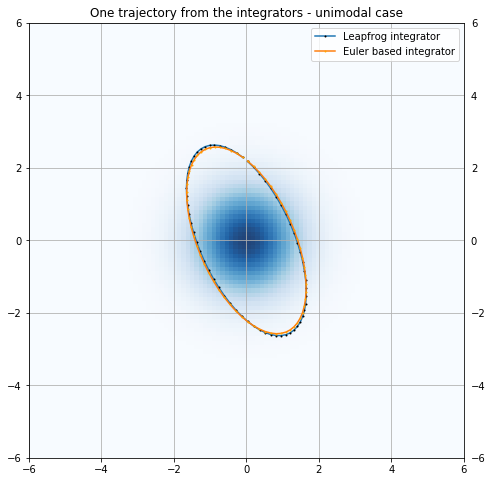

In [11]:
q, p = 2*np.random.randn(2, 2)
_, _, positions_leap, momentums_leap = leapfrog_integrator(q, p, gradV, 2 * np.pi, 0.1)
_, _, positions_euler, momentums_euler = euler_integrator(q, p, gradV, 2 * np.pi, 0.1)
fig = plt.figure(figsize=(8,8))
plt.title('One trajectory from the integrators - unimodal case')

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_density(np.array((Xplot[i][j], Yplot[i][j]))))

plt.imshow(Zplot, alpha=0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.plot(positions_leap[:,0], positions_leap[:,1], marker='o', markersize = 1, markeredgecolor='black', label = 'Leapfrog integrator')
plt.plot(positions_euler[:,0], positions_euler[:,1], marker='o', markersize = 1, markeredgecolor='orange', label = 'Euler based integrator')
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

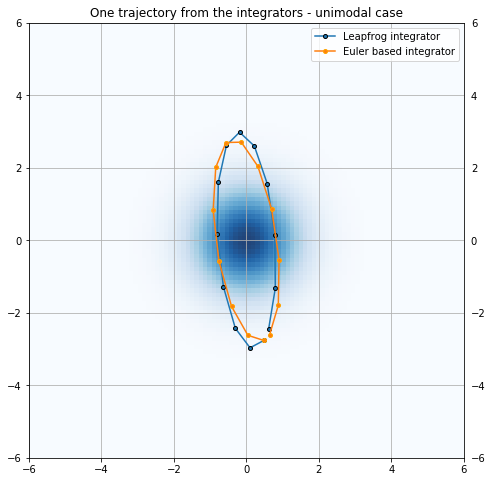

In [12]:
q, p = np.random.randn(2, 2)
_, _, positions_leap, momentums_leap = leapfrog_integrator(q, p, gradV, 2 * np.pi, 0.5)
_, _, positions_euler, momentums_euler = euler_integrator(q, p, gradV, 2 * np.pi, 0.5)
fig = plt.figure(figsize=(8,8))
plt.title('One trajectory from the integrators - unimodal case')
plt.imshow(Zplot, alpha=0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.plot(positions_leap[:,0], positions_leap[:,1], marker='o', markersize = 4, markeredgecolor='black', label = 'Leapfrog integrator')
plt.plot(positions_euler[:,0], positions_euler[:,1], marker='o', markersize = 4, markeredgecolor='orange', label = 'Euler based integrator')
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

<font color=darkred> Display several trajectories of the leapfrog integrator for a 2-dimensional Gaussian target distribution. </font>

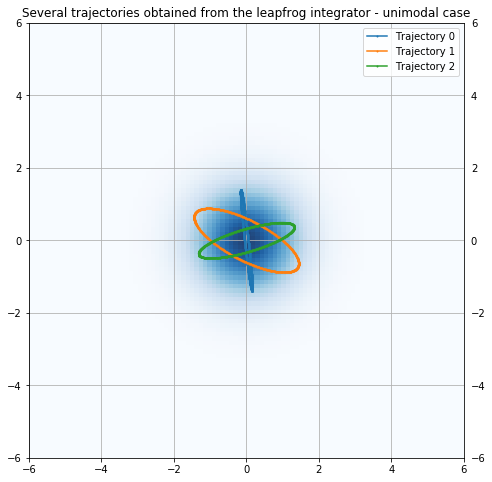

In [13]:
fig = plt.figure(figsize=(8,8))
plt.title('Several trajectories obtained from the leapfrog integrator - unimodal case')
positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, pos, moms = leapfrog_integrator(q, p, gradV, 2 * np.pi, 0.01)
    positions.append(pos)
    momentums.append(moms)

plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap = 'Blues', origin = 'top')

for idx_traj in range(3):
    plt.plot(positions[idx_traj][:,0], positions[idx_traj][:,1], marker='o', markersize = 1, label = 'Trajectory %g'%idx_traj)
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

<font color=darkred> Display several trajectories of the leapfrog integrator for a target defined as a mixture of 2-dimensional Gaussian distributions. </font>

In [14]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

mu3 = np.array([-1.5, 2.2])
cov3 = 0.8 * np.eye(2)

logp  = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2), multi_gauss(mu3, cov3)], [0.25, 0.35, 0.4])
gradV = grad(logp)


positions, momentums = [], []
for it in range(5):
    q, p = np.random.randn(2, 2)
    _, _, pos, moms = leapfrog_integrator(q, p, gradV, 4 * np.pi, 0.01)
    positions.append(pos)
    momentums.append(moms)

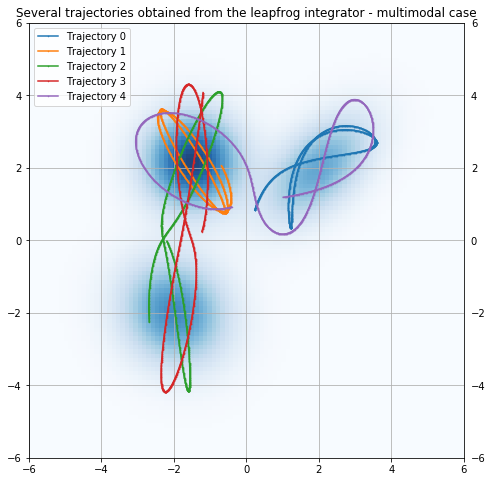

In [15]:
fig = plt.figure(figsize=(8,8))
plt.title('Several trajectories obtained from the leapfrog integrator - multimodal case')

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-logp(np.array((Xplot[i][j], Yplot[i][j]))))

plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap = 'Blues', origin = 'top')

for idx_traj in range(5):
    plt.plot(positions[idx_traj][:,0], positions[idx_traj][:,1], marker='.', markersize = 1, label = 'Trajectory %g'%idx_traj)
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

<font color=darkred> Compare the proposed moves with the moves proposed by MALA and random walk Metropolis-Hastings. </font>

In [73]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

logp  = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2)], [0.5,0.5])
gradV = grad(logp)


positions, momentums = [], []
positions_MALA = []
positions_HM   = []

q, p = 0.5*np.random.randn(2, 2)
grad_new = gradV(q)

for it in range(20):
    _, _, pos, moms = leapfrog_integrator(q, p, gradV, 6* np.pi, 0.01)
    
    step     = (it + 5)/20
    mean_new = q - 0.5*step**2*grad_new
    q_MALA  = mean_new + step*st.norm(0, 1).rvs(2)
    q_HM    = q + step*st.norm(0, 1).rvs(2)
    
    positions.append(pos)
    positions_MALA.append(q_MALA)
    positions_HM.append(q_HM)
    momentums.append(moms)

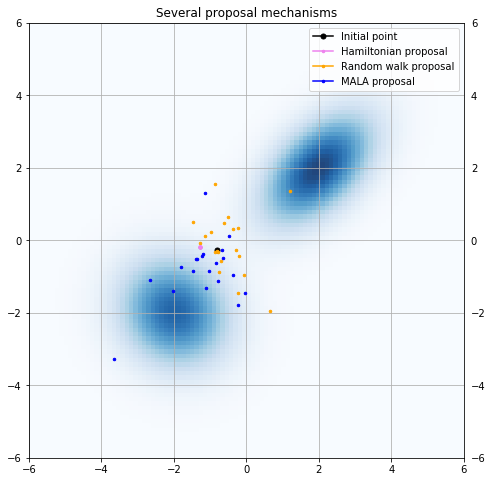

In [74]:
fig = plt.figure(figsize=(8,8))
plt.title('Several proposal mechanisms')

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-logp(np.array((Xplot[i][j], Yplot[i][j]))))

plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap = 'Blues', origin = 'top')

plt.plot(q[0], q[1], marker='.', markersize = 10, color = 'black', label = 'Initial point')
for idx_traj in range(19):
    plt.plot(positions[idx_traj][-1,0], positions[idx_traj][-1,1], marker='.', markersize = 5, color = 'violet')
    plt.plot(positions_HM[idx_traj][0], positions_HM[idx_traj][1], marker='.', markersize = 5, color = 'orange')
    plt.plot(positions_MALA[idx_traj][0], positions_MALA[idx_traj][1], marker='.', markersize = 5, color = 'blue')

plt.plot(positions[19][-1,0], positions[19][-1,1], marker='.', markersize = 5, color = 'violet', label = 'Hamiltonian proposal')
plt.plot(positions_HM[19][0], positions_HM[19][1], marker='.', markersize = 5, color = 'orange', label = 'Random walk proposal')
plt.plot(positions_MALA[19][0], positions_MALA[19][1], marker='.', markersize = 5, color = 'blue', label = 'MALA proposal')
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

### <font color=darkorange> The Hamiltonian loop </font>

<font color=darkred> Use the leapfrog function to write a Hamiltonian loop i.e. a Hamiltonian MCMC with a generic target distribution. </font>

In [75]:
def hamiltonian_monte_carlo(n_samples, log_prob, initial_position, T = 1, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return.
    log_prob: opposite of the target log probability.
    initial_position: a place to start sampling from.
    T: length of leapfrog integration.
    step_size: step size of the integration scheme.
    
    Outputs
    -------
    samples: samples produced by the HMC.
    sample_positions: positions obtained by the leapfrog integrator at each time step.
    sample_momentums: momentums obtained by the leapfrog integrator at each time step.
    accepted: array of 0 and 1 to display which proposed moves have been accepted.
    """
    initial_position = np.array(initial_position)
    
    gradV = grad(log_prob)

    samples = [initial_position]
    sample_positions, sample_momentums = [], []
    accepted = []

    size = (n_samples,) + initial_position.shape[:1]
    
    # all momentums
    momentum = st.norm(0, 1).rvs(size)
    
    for p0 in tqdm(momentum):
        q_new, p_new, positions, momentums = leapfrog_integrator(samples[-1], p0, gradV, 2 * np.random.rand() * T,step_size)
        sample_positions.append(positions)
        sample_momentums.append(momentums)

        # acceptance rate
        old_log_p = log_prob(samples[-1]) - np.sum(st.norm(0, 1).logpdf(p0))
        new_log_p = log_prob(q_new) - np.sum(st.norm(0, 1).logpdf(p_new))
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(sample_positions),np.array(sample_momentums),np.array(accepted),)

<font color=darkred> Display several trajectories of the HMC loop for a Gaussian target distribution </font>

<font color=darkred>i) Illustrate the influence of the total length of the leapfrog integrator. </font>

<font color=darkred>ii) Illustrate the influence of the step size of the leapfrog integrator. </font>

<font color=darkred>iii) Compare the performance with a HM algorithm. </font>

<font color=darkred>iv) Compare the performance with a MALA algorithm. </font>

In [76]:
log_p = multi_gauss(np.zeros(2), np.eye(2))

n_samples = 50
step_size = 0.01
all_T = [1, 5, 10, 15]
samples_HMC = []
positions_HMC = []
momentums_HMC = []

for T in all_T:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, log_p, np.random.randn(2), T, step_size)
    samples_HMC.append(samples)
    positions_HMC.append(positions)
    momentums_HMC.append(momentums)

100%|██████████| 50/50 [00:24<00:00,  1.46it/s]


In [77]:
samples_HM, accepted_HM = HM_monte_carlo(50*n_samples, log_p, np.random.randn(2), 0.1)

100%|██████████| 2500/2500 [00:00<00:00, 15343.90it/s]


In [ ]:
samples_Mala, accepted_Mala = MALA_monte_carlo(50*n_samples, log_p, np.random.randn(2), 0.1)

In [ ]:
fig = plt.figure(figsize=(14,14))
ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222) 
ax3  = fig.add_subplot(223)
ax4  = fig.add_subplot(224)
ax1.set_title('Length of the leapfrog: %g'%all_T[0])
ax2.set_title('Length of the leapfrog: %g'%all_T[1])
ax3.set_title('Length of the leapfrog: %g'%all_T[2])
ax4.set_title('Length of the leapfrog: %g'%all_T[3])

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))

ax1.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax1.plot(samples_HMC[0][:,0], samples_HMC[0][:,1], '.', color='black', label = 'Hamiltonian')
ax1.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6, label = 'Metropolis-Hastings')
ax1.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6, label = 'MALA')
ax1.grid(True)
for i in range(n_samples):
    ax1.plot(positions_HMC[0][i][:, 0], positions_HMC[0][i][:, 1], 'k--', lw = 1, alpha = 0.2)
ax1.legend()

ax2.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax2.plot(samples_HMC[1][:,0], samples_HMC[1][:,1], '.', color='black')
ax2.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax2.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax2.grid(True)
for i in range(n_samples):
    ax2.plot(positions_HMC[1][i][:, 0], positions_HMC[1][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax3.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax3.plot(samples_HMC[2][:,0], samples_HMC[2][:,1], '.', color='black')
ax3.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax3.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax3.grid(True)
for i in range(n_samples):
    ax3.plot(positions_HMC[2][i][:, 0], positions_HMC[2][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax4.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax4.plot(samples_HMC[3][:,0], samples_HMC[3][:,1], '.', color='black')
ax4.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax4.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax4.grid(True)
for i in range(n_samples):
    ax4.plot(positions_HMC[3][i][:, 0], positions_HMC[3][i][:, 1], 'k--', lw = 1, alpha = 0.2)

<font color=darkred> Display several trajectories of the HMC algorithm for a target defined as a mixture of Gaussian distributions. </font>

<font color=darkred>i) Illustrate the influence of the total length of the leapfrog integrator. </font>

<font color=darkred>ii) Illustrate the influence of the step size of the leapfrog integrator. </font>

<font color=darkred>iii) Compare the performance with a HM algorithm. </font>

<font color=darkred>iv) Compare the performance with a MALA algorithm. </font>

In [ ]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

mu3 = np.array([-1.5, 2.2])
cov3 = 0.8 * np.eye(2)

mu4 = np.array([2.5, -4.2])
cov4 = 0.5 * np.eye(2)

log_p = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2), multi_gauss(mu3, cov3), multi_gauss(mu4, cov4)], [0.25, 0.35, 0.3,0.1])

<font color=darkred>Total length of the leapfrog integrator. </font>

In [ ]:
n_samples = 250
step_size = 0.01
all_T = [1, 5, 10, 15]
samples_HMC = []
positions_HMC = []
momentums_HMC = []

for T in all_T:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, log_p, np.random.randn(2), T, step_size)
    samples_HMC.append(samples)
    positions_HMC.append(positions)
    momentums_HMC.append(momentums)

In [ ]:
samples_HM, accepted_HM = HM_monte_carlo(50*n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
samples_Mala, accepted_Mala = MALA_monte_carlo(50*n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
fig = plt.figure(figsize=(14,14))
ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222) 
ax3  = fig.add_subplot(223)
ax4  = fig.add_subplot(224)
ax1.set_title('Length of the leapfrog: %g'%all_T[0])
ax2.set_title('Length of the leapfrog: %g'%all_T[1])
ax3.set_title('Length of the leapfrog: %g'%all_T[2])
ax4.set_title('Length of the leapfrog: %g'%all_T[3])

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))

ax1.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax1.plot(samples_HMC[0][:,0], samples_HMC[0][:,1], '.', color='black', label = 'Hamiltonian')
ax1.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6, label = 'Metropolis-Hastings')
ax1.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6, label = 'MALA')
ax1.grid(True)
for i in range(n_samples):
    ax1.plot(positions_HMC[0][i][:, 0], positions_HMC[0][i][:, 1], 'k--', lw = 1, alpha = 0.2)
ax1.legend()
    
ax2.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax2.plot(samples_HMC[1][:,0], samples_HMC[1][:,1], '.', color='black')
ax2.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax2.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax2.grid(True)
for i in range(n_samples):
    ax2.plot(positions_HMC[1][i][:, 0], positions_HMC[1][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax3.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax3.plot(samples_HMC[2][:,0], samples_HMC[2][:,1], '.', color='black')
ax3.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax3.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax3.grid(True)
for i in range(n_samples):
    ax3.plot(positions_HMC[2][i][:, 0], positions_HMC[2][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax4.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax4.plot(samples_HMC[3][:,0], samples_HMC[3][:,1], '.', color='black')
ax4.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax4.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax4.grid(True)
for i in range(n_samples):
    ax4.plot(positions_HMC[3][i][:, 0], positions_HMC[3][i][:, 1], 'k--', lw = 1, alpha = 0.2)

<font color=darkred>Step-size of the leapfrog integrator. </font>

In [ ]:
n_samples = 250
step_size = 0.01
all_epsilon = [0.005,0.01,0.05,0.1]
T           = 5
samples_HMC = []
positions_HMC = []
momentums_HMC = []

for epsilon in all_epsilon:
    samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, log_p, np.random.randn(2), T, epsilon)
    samples_HMC.append(samples)
    positions_HMC.append(positions)
    momentums_HMC.append(momentums)

In [ ]:
samples_HM, accepted_HM = HM_monte_carlo(50*n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
samples_Mala, accepted_Mala = MALA_monte_carlo(50*n_samples, log_p, np.random.randn(2), step_size)

In [ ]:
fig = plt.figure(figsize=(14,14))
ax1  = fig.add_subplot(221)
ax2  = fig.add_subplot(222) 
ax3  = fig.add_subplot(223)
ax4  = fig.add_subplot(224)
ax1.set_title('Step-size of the leapfrog: %g'%all_epsilon[0])
ax2.set_title('Step-size of the leapfrog: %g'%all_epsilon[1])
ax3.set_title('Step-size of the leapfrog: %g'%all_epsilon[2])
ax4.set_title('Step-size of the leapfrog: %g'%all_epsilon[3])

Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))

ax1.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax1.plot(samples_HMC[0][:,0], samples_HMC[0][:,1], '.', color='black', label = 'Hamiltonian')
ax1.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6, label = 'Metropolis-Hastings')
ax1.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6, label = 'MALA')
ax1.grid(True)
for i in range(n_samples):
    ax1.plot(positions_HMC[0][i][:, 0], positions_HMC[0][i][:, 1], 'k--', lw = 1, alpha = 0.2)
ax1.legend()
    
ax2.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax2.plot(samples_HMC[1][:,0], samples_HMC[1][:,1], '.', color='black')
ax2.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax2.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax2.grid(True)
for i in range(n_samples):
    ax2.plot(positions_HMC[1][i][:, 0], positions_HMC[1][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax3.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax3.plot(samples_HMC[2][:,0], samples_HMC[2][:,1], '.', color='black')
ax3.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax3.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax3.grid(True)
for i in range(n_samples):
    ax3.plot(positions_HMC[2][i][:, 0], positions_HMC[2][i][:, 1], 'k--', lw = 1, alpha = 0.2)
    
ax4.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
ax4.plot(samples_HMC[3][:,0], samples_HMC[3][:,1], '.', color='black')
ax4.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.6)
ax4.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.6)
ax4.grid(True)
for i in range(n_samples):
    ax4.plot(positions_HMC[3][i][:, 0], positions_HMC[3][i][:, 1], 'k--', lw = 1, alpha = 0.2)

### <font color=darkorange> Parameters tuning </font>

<font color=darkred>Analyze the optimal tuning of the HMC parameters: variance matrix of the momentums, step-size, length of the symplectic integration...</font>

<font color=darkred>Replace the isotropic Gaussian distribution by an empirical estimate of the covariance distribution.</font>

### <font color=darkorange> Time series: Brazilian inflation </font>

In [ ]:
# In this section, random forests are used to predic the Brazilian inflation based on
# many observed variables, see https://github.com/gabrielrvsc/HDeconometrics/
df = pd.read_csv('./BRinf')
df.head()

In [ ]:
df.columns[2]

In [ ]:
fig = plt.figure(figsize = (12,12))
#for i in range(5):
#    plt.plot(df.iloc[:,i+2].values,'.-', alpha = 0.8, label = df.columns[i+2])
plt.plot(df.iloc[:,1].values,'.-', alpha = 0.8, label = df.columns[1])
plt.xlabel('Time (month)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=20);

In [ ]:
# number of observations, number of variables
df.shape

The function ``pandas.DataFrame.corr`` may be used to compute the pairwise correlations between columns (variables and inflation). These correlations can be displayed using ``sns.heatmap`` to highlight highly correlated variables (and those likely to have an impact on the inflation).

See ``feature_importances_`` below for a first try at (relevant) variable selection.

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, xticklabels = False, yticklabels = False, cmap = 'Blues', ax = ax)

In [ ]:
corr.head()

In [ ]:
nb_data_train = 144
nb_diff       = df.shape[0]-nb_data_train
# inflation observations
Y_train = df.iloc[0:nb_data_train,1] 
Y_test  = df.iloc[-nb_diff:,1] 
Y_test.head()

In [ ]:
# other variables
X_train = df.iloc[0:nb_data_train,2:] 
X_test  = df.iloc[-nb_diff:,2:] 
X_test.head()

Consider a sequence of covariables $(X_k)_{k\geqslant 0}$ in $\mathbb{R}^d$.

The observation model for the inflation is

$$ 
Y_k = f(X_k) + \sigma_Y\eta_{k}\,,
$$

where $(\eta_k)_{k\geqslant 0}$ are i.i.d. $\sim N(0,1)$.

The objective is to estimate the function $f$ using a training data set to predict the observations associated with the test dataset.

##### <font color=darkcyan> Observed covariates </font>

Assume firt that the $(X_k)_{k\geqslant 0}$ are observed and that only $f$ has to be estimated.
A random forest may be used to  estimate $f$ with striking performance.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'));

Many variables are used for the inflation prediction while very few observations are available.
Selecting the most valuable variables is an alternativ to learn a simpler models
This is obtained in Python with rf.feature_importances_

In [ ]:
plt.figure(1,figsize=(12,12))
plt.bar(list(df)[2:93],rf.feature_importances_,align='center')
plt.xticks(range(len(list(df)[2:93])),list(df)[2:93],rotation=90,size='small')
plt.title('Feature importances');

RandomForestClassifier and RandomForestRegressor use the gini importance mechanism as a measure of the 
fetaures importance, see https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf

In [ ]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 3
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind].head()

In [ ]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

##### <font color=darkcyan> Unobserved covariates </font>

Assume now that only a few $(X_k)_{0\leqslant k \leqslant p}$ are observed.
A HMC algorithm may be used to sample from the posterior distribution of the unknown parameters.
The samples may then be used to predict $(X_k)_{p+1\leqslant k \leqslant n}$ in order to forecast 
the Brazilian inflation.

In [ ]:
X_train_small = X_train.iloc[2:144,ind]
X_train_small.head()
X_train_small.shape

In [ ]:
X_test_small = X_test.iloc[:,ind]
X_test_small.head()

Consider a Markov chain which describes the economics covariables, given by $X_0 = x_0$ for $x_0\in \mathbb{R}^d$ and, for $k\geqslant 0$,

$$
X_{k+1} = A X_k + \sigma_X\varepsilon_k\,,
$$ 

where $(\epsilon_k)_{k\geqslant 0}$ are i.i.d. standard Gaussian vectors in $\mathbb{R}^d$ $\sim {\sf N}(0,{\bf I}_d)$.

The observation model for the inflaction is

$$ 
Y_k = f(X_k) + \sigma_Y\eta_{k}\,,
$$

where $(\eta_k)_{k\geqslant 0}$ are i.i.d. $\sim N(0,1)$.The objective is to estimate the function $f$ using a training data set to predict the observations associated with the test dataset.

In [ ]:
def target_inflation(Xobs):
    """
    Inputs
    -------
    param: these parameters are the entries of A
    
    Output
    -------
    log_density: the opposite of the log pdf of a Markov chain model for the economics covariables.
    """
    
    nb_obs = Xobs.shape[0]
    def log_density(x):
        loglikelihood = 0 
        A   = np.diag(x)#x.reshape((3,3))
        for j in range(nb_obs-1):
            minuslogp = multi_gauss(np.dot(A,Xobs[j,:]), 0.3*np.eye(3))
            loglikelihood = loglikelihood + minuslogp(Xobs[j+1,:])
        
        minuslogp     = multi_gauss(np.ones(3), 0.3*np.eye(3))
        loglikelihood = loglikelihood + minuslogp(x)
        
        return loglikelihood

    return log_density

In [ ]:
n_samples = 50
neg_log_p = target_inflation(X_train_small.values)
samples, positions, momentums, accepted = hamiltonian_monte_carlo(n_samples, neg_log_p, np.ones(3) + np.random.randn(3), path_len = 1, step_size = 0.1)

In [ ]:
fig = plt.figure(figsize=(16,8))
ax1  = fig.add_subplot(131)
ax2  = fig.add_subplot(132) 
ax3  = fig.add_subplot(133) 
ax1.set_title('Parameter associated with covariate 1')
ax2.set_title('Parameter associated with covariate 2')
ax3.set_title('Parameter associated with covariate 3')
sns.distplot(samples[:,0], rug = False, kde = True, bins = 15, ax=ax1)
ax1.grid(True)
sns.distplot(samples[:,1], rug = False, kde = True, bins = 15, ax=ax2)
ax2.grid(True)
sns.distplot(samples[:,2], rug = False, kde = True, bins = 15, ax=ax3);
ax3.grid(True)

In [ ]:
X_test_pred = X_test_small.values
X_test_pred
#X_test_pred.shape[0]

In [ ]:
X_test_small.values

In [ ]:
X_test_pred = X_test_small.values
for j in range(X_test_pred.shape[0]-1):
    X_test_pred[j+1,:] = np.dot(A,X_test_pred[j,:]) + 0.3*np.random.normal(0,1,3)
df = pd.DataFrame(X_test_pred, columns = ['Cov 1', 'Cov2', 'Cov3']) 
df.head()

X_test_pred = X_test_small.values
for j in range(X_test_pred.shape[0]-1):
    X_test_pred[j+1,:] = np.dot(A,X_test_pred[j,:]) + 0.3*np.random.normal(0,1,3)
df1 = pd.DataFrame(X_test_pred, columns = ['Cov 1', 'Cov2', 'Cov3']) 
df.head()

X_test_pred = X_test_small.values
for j in range(X_test_pred.shape[0]-1):
    X_test_pred[j+1,:] = np.dot(A,X_test_pred[j,:]) + 0.3*np.random.normal(0,1,3)
df2 = pd.DataFrame(X_test_pred, columns = ['Cov 1', 'Cov2', 'Cov3']) 

In [ ]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

y_pred_hmc = rf.predict(df)
y_pred_hmc1 = rf.predict(df1)
y_pred_hmc2 = rf.predict(df2)

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.plot(y_pred_hmc,'b--',marker='.')
plt.legend(labels=('Future inflation values','Random forest estimates with observed covariates','Random forest estimates with predicted covariates'));

## <font color=darkcyan> Approximate Bayesian Computation </font>

The ``Lotka-Volterra equations,`` also known as the ``predator–prey equations,`` are a pair of first-order nonlinear differential equations used to describe the dynamics of biological systems in which two species interact. 

The populations change through time according to the following model:

\begin{align*}
\mathrm{d} X_t &= (\alpha X_t - \beta X_tY_t)\mathrm{d} t\,,\\
\mathrm{d} Y_t &= (\delta X_tY_t - \gamma Y_t)\mathrm{d}t\,.
\end{align*}

The parameters of this model are $\alpha$, $\beta$, $\delta$ and $\gamma$.

<font color=darkred> Write a function to sample a noisy solution to the Lokta-Volterra equations. </font>

In [121]:
def lotka_volterra(alpha, delta, beta, gamma, x_init, y_init, T = 10, deltat = 0.1, sigma = 0.1):
    size_samples = int(T/deltat)+2
    
    x = np.zeros(size_samples)
    y = np.zeros(size_samples)
    t = np.zeros(size_samples)
    
    x[0] = x_init
    y[0] = y_init
    t[0] = 0
    
    idx = 0
    
    while t[idx] < T:
        dx = (alpha * x[idx] - beta * x[idx] * y[idx]) * deltat
        dy = (delta * x[idx] * y[idx] - gamma * y[idx]) * deltat
        x[idx + 1] = x[idx] + dx
        y[idx + 1] = y[idx] + dy
        t[idx + 1] = t[idx] + deltat
        idx = idx + 1
    
    x = x + np.random.normal(0, sigma, size_samples)
    y = y + np.random.normal(0, sigma, size_samples)
    
    return x, y, t 

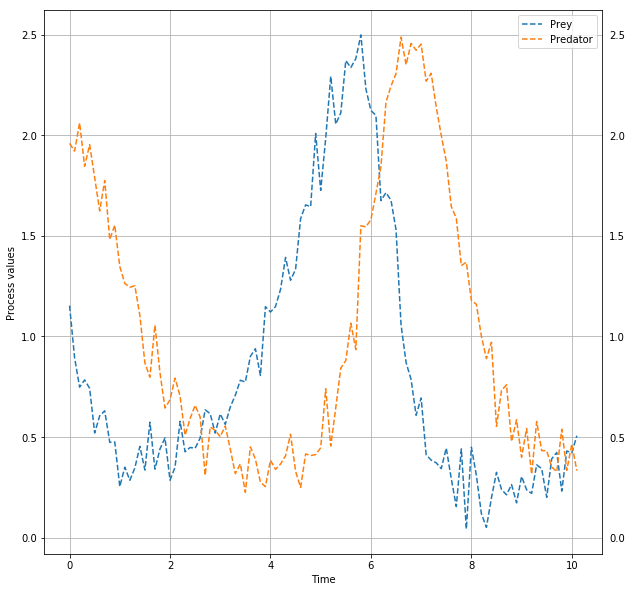

In [122]:
alpha = 1
delta = 1
beta  = 1
gamma = 1

x_init = 1
y_init = 2

T = 10
deltat = 0.1
sigma = 0.1

x, y, t = lotka_volterra(alpha, delta, beta, gamma, x_init, y_init, T, deltat, sigma)

plt.figure(figsize=(10,10))
plt.plot(t, x, linestyle = 'dashed', label = 'Prey')
plt.plot(t, y, linestyle = 'dashed', label = 'Predator')
plt.tick_params(labelright=True)
plt.grid(True)

plt.xlabel('Time')
plt.ylabel('Process values')
plt.legend()
plt.show()

### <font color=darkorange> ABC rejection sampling </font>

The ``ABC with summary statistics`` proceeds as follows.

- Sample $\widetilde \theta \sim \pi$.

- Sample $\widetilde Y \sim \ell(\cdot|\widetilde \theta)$ and compute $S(\widetilde Y)$.

- $\mathsf{d}(S(Y),S(\widetilde Y))<\varepsilon$.

<font color=darkred> Start with the distance between samples defined as the $L_2$ norm between trajectories. </font>

In [123]:
def dist_obs(x_samp, y_samp, x_true, y_true):
    return np.sum(np.square(x_samp - x_true) + np.square(y_samp - y_true))

<font color=darkred> Write a function to sample parameters using ABC rejection sampling. </font>

In [124]:
def ABC_rejection(x_init, y_init, T, deltat, sigma, x, y, bound_min = 0.2, bound_sup = 1.5, epsilon = 5, n_samples = 1000):
    alpha_samples = np.zeros(n_samples)
    delta_samples = np.zeros(n_samples)
    generations = 0
    count = 0
    while count < n_samples:
        alpha_prop, delta_prop = np.random.uniform(bound_min,bound_sup,2)
        x_sim, y_sim, t_sim = lotka_volterra(alpha_prop, delta_prop, 1, 1, x_init, y_init, T, deltat, sigma)
        
        d = dist_obs(x_sim, y_sim, x, y)
        if d < epsilon:
            alpha_samples[count] = alpha_prop
            delta_samples[count] = delta_prop
            count = count + 1
    return alpha_samples, delta_samples

<font color=darkred> Compare the performance with respect to the value of epsilon. </font>

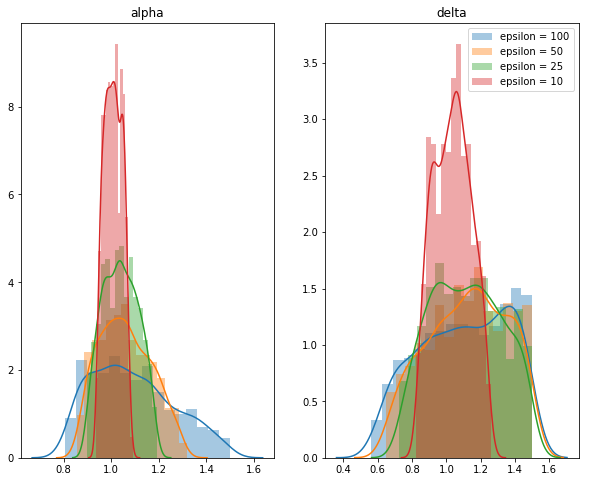

In [125]:
fig = plt.figure(figsize=(10,8))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122) 

ax1.set_title('alpha')
ax2.set_title('delta')

for eps in [100,50,25,10]:
    alpha_samples, delta_samples = ABC_rejection(x_init, y_init, T, deltat, sigma, x, y, bound_min = 0.1, bound_sup = 1.5, epsilon = eps, n_samples = 1000)
    sns.distplot(alpha_samples, rug = False, kde = True, bins = 15, ax=ax1, label = 'epsilon = %g'%eps)
    sns.distplot(delta_samples, rug = False, kde = True, bins = 15, ax=ax2, label = 'epsilon = %g'%eps)
plt.legend();

<font color=darkred> Compare with another distance (you may try the Wassertein metric, eplicit in this scalar case).</font>

### <font color=darkorange> ABC Markov Chain Monte Carlo sampling </font>

``ABC Markov Chain Monte Carlo sampling`` proceeds as follows.

- Start with $(\theta_0,Y_0)$.


- For all $1\leqslant i\leqslant N$, 
   
   __ Sample $\widetilde \theta \sim q(\cdot |\theta_i)$.

   __ Sample $\widetilde Y \sim \ell(\cdot|\widetilde \theta)$ and compute $S(\widetilde Y)$.
  
   __ If $\mathsf{d}(S(Y),S(\widetilde Y))>\varepsilon$, set $\theta_{i+1} = \theta_i$ and $Y_{i+1} = Y_i$.
   
   __ Else 
   
   ____Compute $\alpha = 1\wedge \frac{\pi(\widetilde \theta) q(\theta_i|\widetilde \theta)}{\pi(\theta_i) q(\widetilde\theta| \theta_i)}$.
       
   ____Sample $U\sim U(0,1)$.
       
   ____If $U< \alpha$, set $\theta_{i+1} = \widetilde \theta$ and $Y_{i+1} = \widetilde Y_i$. 
       
   ____Else set $\theta_{i+1} = \theta_i$ and $Y_{i+1} = Y_i$.

<font color=darkred> Write a function to propose new parameter values using a Gaussian random variables. </font>

<font color=darkred> Write a function to compute the acceptance rate. </font>

In [126]:
def proposed_move(alpha, delta, sigma):
    
    alpha_prop = np.random.normal(alpha,sigma)
    delta_prop = np.random.normal(delta,sigma)
    
    return alpha_prop, delta_prop

In [127]:
def acceptance_rate(alpha_prop, delta_prop, alpha_init, delta_init, sigma = 0.1, bound_min = 0.2, bound_sup = 1.5):
    
    num = scipy.stats.uniform(bound_min,bound_sup).pdf(alpha_prop)*scipy.stats.uniform(bound_min,bound_sup).pdf(delta_prop)
    num = num*scipy.stats.norm(alpha_prop,sigma).pdf(alpha_init)*scipy.stats.norm(delta_prop,sigma).pdf(delta_init)
    
    den = scipy.stats.uniform(bound_min,bound_sup).pdf(alpha_init)*scipy.stats.uniform(bound_min,bound_sup).pdf(delta_init)
    den = den*scipy.stats.norm(alpha_init,sigma).pdf(alpha_prop)*scipy.stats.norm(delta_init,sigma).pdf(delta_prop)
    
    return num/den

<font color=darkred> Write a function to compute a ABC MCMC loop. </font>

In [128]:
def ABC_MCMC(alpha_init, delta_init, x_init, y_init, T, deltat, sigma, x, y, bound_min = 0.2, bound_sup = 1.5, epsilon = 5, n_samples = 1000):
 
    alpha_chain = np.zeros(n_samples)
    delta_chain = np.zeros(n_samples)

    alpha_chain[0] = alpha_init 
    delta_chain[0] = delta_init

    for i in range(n_samples-1):
        alpha_prop, delta_prop = proposed_move(alpha_chain[i], delta_chain[i], sigma)
    
        x_sim, y_sim, t_sim = lotka_volterra(alpha_prop, delta_prop, 1, 1, x_init, y_init, T, deltat, sigma)
    
        d = dist_obs(x_sim, y_sim, x, y)
    
        if d < epsilon:         
            acc = acceptance_rate(alpha_prop, delta_prop, alpha_chain[i], delta_chain[i], sigma, bound_min, bound_sup)
            alpha_chain[i+1] = np.random.choice([alpha_prop,alpha_chain[i]],1,p=[acc,1-acc])
            delta_chain[i+1] = np.random.choice([delta_prop,delta_chain[i]],1,p=[acc,1-acc])
        else:
            alpha_chain[i+1] = alpha_chain[i]
            delta_chain[i+1] = delta_chain[i]
            
    return alpha_chain, delta_chain


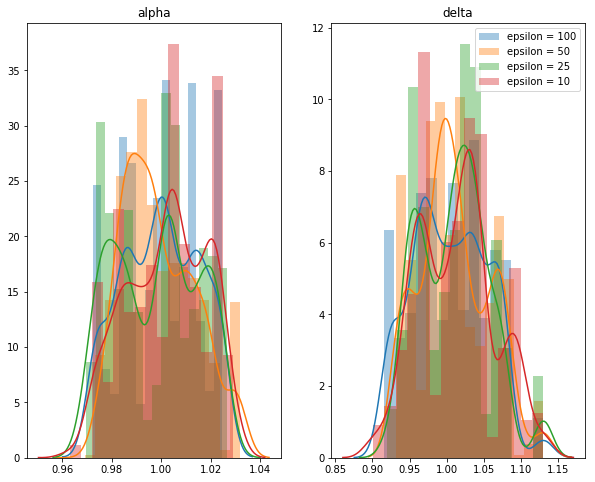

In [129]:
alpha_init = alpha_samples[-1]
delta_init = delta_samples[-1]

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122) 

ax1.set_title('alpha')
ax2.set_title('delta')

for eps in [100, 50, 25, 10]:
    alpha_chain, delta_chain = ABC_MCMC(alpha_init, delta_init, x_init, y_init, T, deltat, sigma, x, y, bound_min = 0.2, bound_sup = 1.5, epsilon = 5, n_samples = 1000)
    sns.distplot(alpha_chain, rug = False, kde = True, bins = 15, ax=ax1, label = 'epsilon = %g'%eps)
    sns.distplot(delta_chain, rug = False, kde = True, bins = 15, ax=ax2, label = 'epsilon = %g'%eps)
plt.legend();

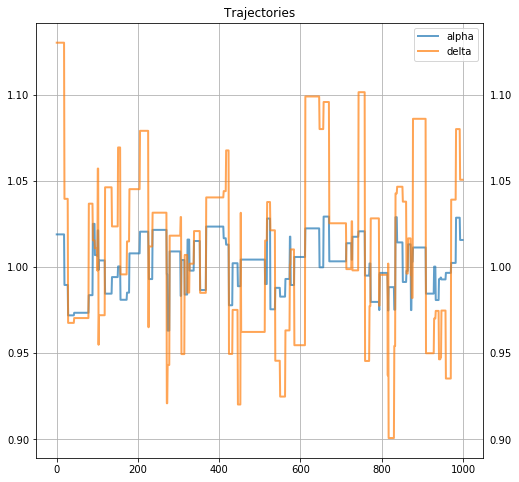

In [130]:
fig = plt.figure(figsize=(8,8))

plt.title('Trajectories')
plt.plot(alpha_chain, linewidth = 2, alpha = 0.7, label = 'alpha')
plt.plot(delta_chain, linewidth = 2, alpha = 0.7, label = 'delta')
plt.tick_params(labelright=True)
plt.grid(True)
plt.legend();

### <font color=darkorange> ABC Sequential Monte Carlo Sampling </font>

<font color=darkred>Implement an ABC MCMC to analyze the influence of decrease of the sequence of threshodlds.</font>

### <font color=darkorange> Count data: delphininae </font>

In [28]:
data = pd.read_csv('dauphins_golfe_de_gascogne.txt', sep="\t", header = 0)

In [29]:
data.head()
data.shape

(1539, 10)

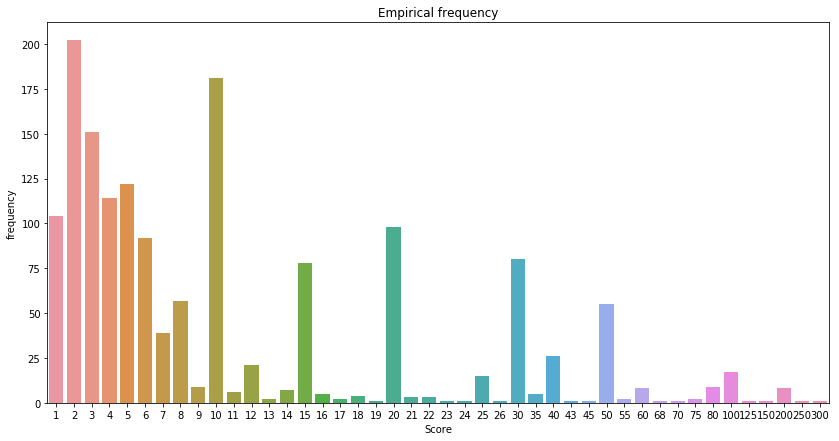

In [30]:
plt.figure(figsize=(14,7))
sns.countplot(x = "nombre", data = data)
plt.ylabel('frequency')
plt.xlabel('Score')
plt.title("Empirical frequency")
plt.show()

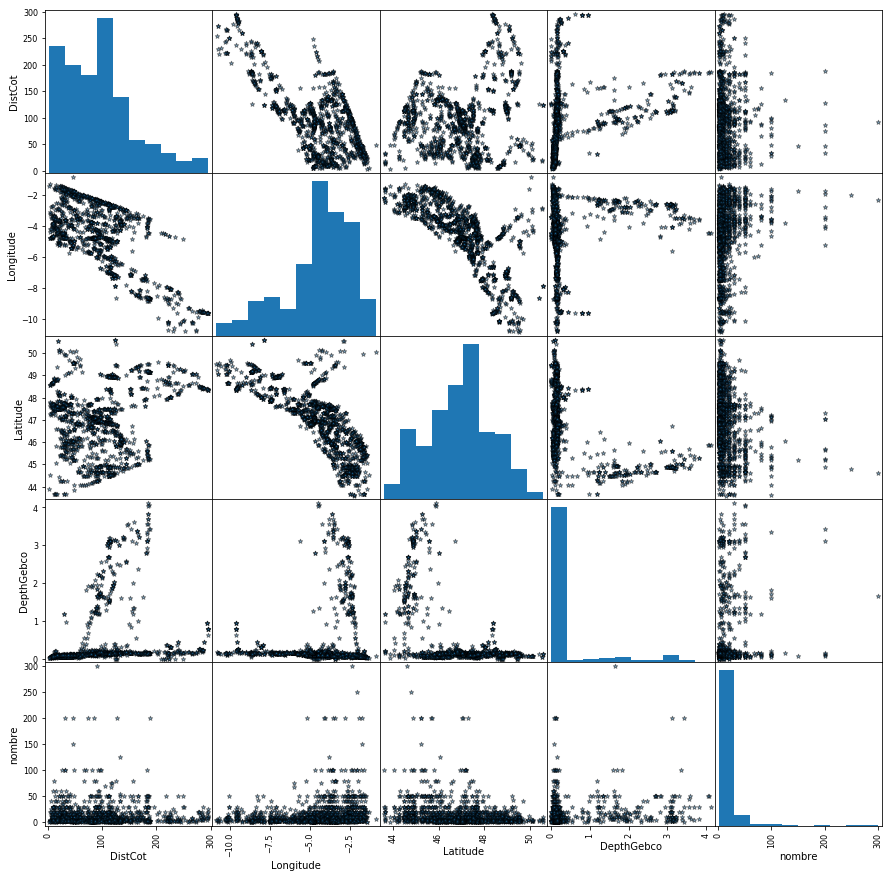

In [31]:
pd.plotting.scatter_matrix(data.loc[:,["DistCot","Longitude","Latitude","DepthGebco","nombre"]],
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 20,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

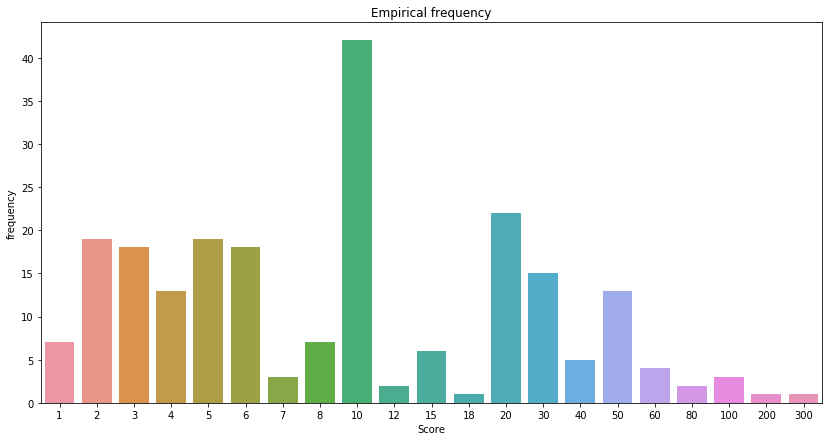

In [32]:
plt.figure(figsize=(14,7))
sns.countplot(x = "nombre", data = data[data['an'] == 2010])
plt.ylabel('frequency')
plt.xlabel('Score')
plt.title("Empirical frequency")
plt.show() 